# 01 Image Classification

## What is image classification?

The task of identifying what an image represents is called image classification. An image classification model is trained to recognize various classes of images. For example, you may train a model to recognize photos representing three different types of animals: rabbits, hamsters, and dogs.

In this tutorial, we will focus on deep learning image classification using tensorflow.

![image](notebook_image/0001.png)

## What is tensorflow?

Tensorflow is Google’s Open Source Machine Learning Framework for dataflow programming across a range of tasks. Nodes in the graph represent mathematical operations, while the graph edges represent the multi-dimensional data arrays (tensors) communicated between them.

Tensors are just multidimensional arrays, an extension of 2-dimensional tables to data with a higher dimension. There are many features of Tensorflow which makes it appropriate for Deep Learning. So, without wasting any time, let’s see how we can implement Object Detection using Tensorflow.

![image](notebook_image/002.png)

## How do I know the version of tensorflow that I am using?
The follwoing command can show the tensorflow version that you are using. Meanwhile, there may be several "future warning". It is fine to ignore them since it is just a reminder about some changes are made for future version.

In [1]:
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


## Import necessary libraries

Tensorflow is the library that used for deep learning. However, more functions and tools are required in the program. Therefore, different libraries and modules are imported below.

In [21]:
from PIL import Image
import sys
import os
import urllib
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
from tf_trt_models.classification import download_classification_checkpoint, build_classification_graph

%matplotlib inline



## Download the checkpoint and sample image



In [22]:
MODEL = 'inception_v1'
CHECKPOINT_PATH = 'inception_v1.ckpt'
NUM_CLASSES = 1001
LABELS_PATH = './data/imagenet_labels_%d.txt' % NUM_CLASSES
IMAGE_PATH = './data/dog.jpeg'

## Pretrained dataset: ImageNet

ImageNet is an image database organized according to the WordNet hierarchy (currently only the nouns), in which each node of the hierarchy is depicted by hundreds and thousands of images. Currently we have an average of over five hundred images per node. We hope ImageNet will become a useful resource for researchers, educators, students and all of you who share our passion for pictures. 

http://www.image-net.org/

In [23]:
checkpoint_path = download_classification_checkpoint(MODEL, 'data')
print("downloaded path:",checkpoint_path)

downloaded path: data/inception_v1/inception_v1.ckpt


## Build the frozen graph

Freezing is the process to identify and save all of the required things such as graph and weights in a single file that can be easily used. A typical Tensorflow models contains 4 files including model-ckpt.meta, model-ckpt.model-ckpt.data-0000-of-00001, model-ckpt.index and checkpoint.


In [24]:
frozen_graph, input_names, output_names = build_classification_graph(
    model=MODEL,
    checkpoint=checkpoint_path,
    num_classes=NUM_CLASSES
)

print("Input names",input_names)
print("Output names",output_names)

INFO:tensorflow:Restoring parameters from data/inception_v1/inception_v1.ckpt
INFO:tensorflow:Froze 230 variables.
INFO:tensorflow:Converted 230 variables to const ops.
Input names ['input']
Output names ['scores']


## Optimized the graph with TensorRT
NVIDIA TensorRT™ is an SDK for high-performance deep learning inference. It includes a deep learning inference optimizer and runtime that delivers low latency and high-throughput for deep learning inference applications.TensorRT is built on CUDA, NVIDIA’s parallel programming model, and enables you to optimize inference for all deep learning frameworks leveraging libraries, development tools and technologies in CUDA-X for artificial intelligence, autonomous machines, high-performance computing, and graphics.

![image](notebook_image/003.png)

1. input_graph_def -> frozen Tensorflow graph
2. outputs -> list of strings with names of output nodes
3. max_batch_size -> integer, size of input batch
4. max_worksapce_size_bytes -> integer, maximum GPU memory size availabele for TensorRT
5. precision_mode -> string, allowed values "FP32", "FP16" OR "INT8"
6. Minimum_segment_size -> integer(default = 3), control minimum number of nodes in a sub-graph for TensorRT engein to be created


In [25]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

INFO:tensorflow:Running against TensorRT version 5.0.6


## Create session and load graph

get_tensor_by_name -> It returns the Tensor with the given name.

In [26]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')

## Download and preprocess image

It will get the dimensions of the image and convert it as a numpy array for further processing.

height of image: 224
width of image: 224


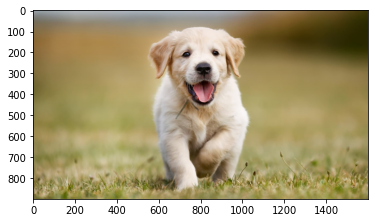

In [27]:
image = Image.open(IMAGE_PATH)

plt.imshow(image)

width = int(tf_input.shape.as_list()[1])
height = int(tf_input.shape.as_list()[2])

image = np.array(image.resize((width, height)))

print("height of image:",height)
print("width of image:",width)

## Execute model by tf_sess.run

In [28]:
output = tf_sess.run(tf_output, feed_dict={tf_input: image[None, ...]})
scores = output[0]
print("scores",scores)

scores [9.95304290e-05 1.07686959e-04 3.97803487e-05 ... 7.59259274e-05
 1.61236763e-04 1.14216506e-04]


## Get top 5 labels

In [29]:
with open(LABELS_PATH, 'r') as f:
    labels = f.readlines()

#Rearrange the scores in decesnding order
top5_idx = scores.argsort()[::-1][0:5]

for i in top5_idx:
    print('(%3f) %s' % (scores[i], labels[i]))

(0.413777) Labrador retriever

(0.165575) golden retriever

(0.135326) Great Pyrenees

(0.041198) clumber, clumber spaniel

(0.037682) kuvasz



## Close the session and release resources

In [30]:
tf_sess.close()

## Challenge

Question 1. How can I get top 10 output labels from the network

Question 2. How can I change the type of network for inferencing?

Question 3. How can I change the path of the input image?

In [ ]:
#You can type your answer here

In [ ]:
#You can type your answer here

In [ ]:
#You can type your answer here

In [ ]:
#You can type your answer here

In [ ]:
#You can type your answer here

## Solutions of question 1

In [ ]:
#Question 1

MODEL = 'inception_v1'
CHECKPOINT_PATH = 'inception_v1.ckpt'
NUM_CLASSES = 1001
LABELS_PATH = './data/imagenet_labels_%d.txt' % NUM_CLASSES

#Change it here
IMAGE_PATH = './data/dog.jpeg'

You have to change the IMAGE_PATH which is corresponding to your new input image.

## Solutions of question 2

In [ ]:
#Question 2

MODEL = 'inception_v1'                   #Model name
CHECKPOINT_PATH = 'inception_v1.ckpt'    #Model checkpoint
NUM_CLASSES = 1001
LABELS_PATH = './data/imagenet_labels_%d.txt' % NUM_CLASSES

#Change it here
IMAGE_PATH = './data/dog.jpeg'

The above settings indicate the model you used.

In [ ]:
checkpoint_path = download_classification_checkpoint(MODEL, 'data')
print("downloaded path:",checkpoint_path)

The function named as "download_classification_checkpoint" will follow the above setting and download the corresponding models. If you want to change the model, you need to change MODEL and CHECKPOINT_PATH. For the models that are avaliable, you can refer to classification.py under the same directory of this notebook.

![image](notebook_image/004.jpg)


## Solutions of question 3

In [ ]:
with open(LABELS_PATH, 'r') as f:
    labels = f.readlines()

top5_idx = scores.argsort()[::-1][0:10]   #Change this from 5 to 10

for i in top5_idx:
    print('(%3f) %s' % (scores[i], labels[i]))